# 10.6 Processing in parallel

*Estimated time for this notebook: 30 minutes.*

For large datasets, processing in-memory on a single thread might be too slow.
There are a few potential options for processing this data in parallel, some of which we'll look at very briefly here (we won't go into any details - for more information you are recommended to look at the linked documentation).

## Batch processing 

One option could be to split your dataset into smaller subsets, and use a batch system to run many jobs in parallel on a cluster or farm of computers.
A popular batch job scheduler is _Slurm_ (https://slurm.schedmd.com/documentation.html) which offers tools for submitting jobs to batch queues, monitoring their progress, and keeping track of failures.
Cloud providers such as Microsoft Azure have their own batch offerings (e.g. _Azure Batch_) with similar features.

However, even with tools such as these, there is usually quite a bit of overhead involved in figuring out how to split up the data, write submission scripts, and keeping track of completed or failed jobs.

## MapReduce 

MapReduce is a programming model for processing data using a cluster of worker nodes, often on a distributed filesystem.
One such implementation is _Apache Hadoop_ https://hadoop.apache.org/. 

MapReduce consists of three main steps: **Map**, **Shuffle**, **Reduce**, which all operate on _key, value_ pairs.  Much of the possible speedup in a MapReduce workflow is if one is able to send "code-to-data", i.e. have expensive "map" operations run on nodes that have fast access to the relevant bit of data.

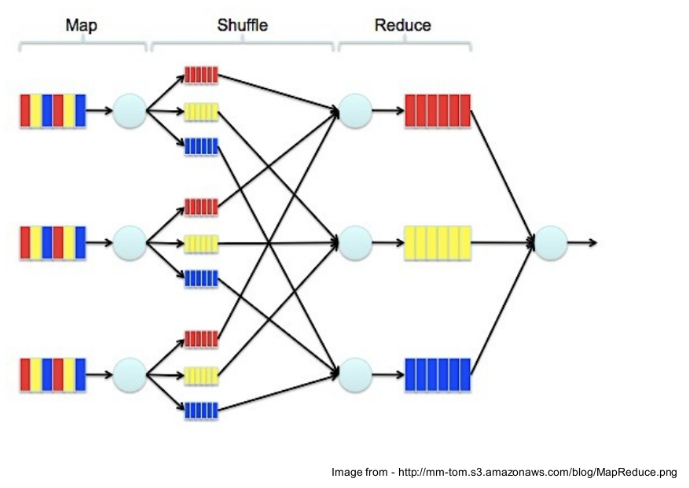

The canonical (trivial) example of MapReduce is a word-count problem - suppose we have a set of text files and we want to count the frequency of occurence of each word.  We want to be able to parallelize, so that each input could processed by one node, and the results are brought together at the end in an efficient manner.

First we write a mapper function that takes a single filename as input, and outputs a sorted list of `{word:[1]}` dicts:

In [1]:
def mapper(input_filename):
    with open(input_filename) as inputfile:
        # split the text on spaces
        words = inputfile.read().split(" ")
        # use list comprehension to output a list of {word: [1]} dicts
        output = [{word.strip(): [1]} for word in sorted(words)]
        return output

In [2]:
mapper("text_sample_0.txt")

[{'best': [1]},
 {'it': [1]},
 {'it': [1]},
 {'of': [1]},
 {'of': [1]},
 {'the': [1]},
 {'the': [1]},
 {'times': [1]},
 {'times': [1]},
 {'was': [1]},
 {'was': [1]},
 {'worst': [1]}]

The next step is to _shuffle_, bringing together all the items in the mapper output with the same key, so that each key's data can be sent to a different _reducer_.

In [3]:
def shuffler(word_dicts):
    output_dict = {}
    for word_dict in word_dicts:
        for k, v in word_dict.items():
            if not k in output_dict.keys():
                output_dict[k] = []
            output_dict[k] += v
    return [{k: v} for k, v in output_dict.items()]

In [4]:
shuffler(mapper("text_sample_0.txt"))

[{'best': [1]},
 {'it': [1, 1]},
 {'of': [1, 1]},
 {'the': [1, 1]},
 {'times': [1, 1]},
 {'was': [1, 1]},
 {'worst': [1]}]

The _reducer_ in this case is very simple - given a key (which is a word), and a value (which is a list `[1,1,1,...]`) sum up the values of the list to return a single value.

In [5]:
def reducer(word_dict):
    return {k: sum(v) for k, v in word_dict.items()}

In [6]:
reducer({"best": [1, 1]})

{'best': 2}

In [7]:
# Map over each input file, locally on the machine where that file is
input_files = [f"text_sample_{i}.txt" for i in range(7)]
mapped_data = map(mapper, input_files)

# Shuffle the data, changing from a distribution where every machine has all the data
# for a single input file, to one in which every machine has all the data for a single
# word. This is the only part that would cause inter-machine data-moving if run on a
# cluster/grid.
# First run the shuffler locally on each machine...
shuffle_outputs = [shuffler(md) for md in mapped_data]
# ... and then again to bring the outputs from the different mapper processes together.
shuffle_outputs = shuffler(sum(shuffle_outputs, []))

# Each machine can then run the reduction operation locally on the data that it has
# post-shuffle. In our case each machine takes care of summing up the subcounts for
# some subset of words.
counts = [reducer(word_dict) for word_dict in shuffle_outputs]
print(counts)

[{'best': 1}, {'it': 10}, {'of': 10}, {'the': 11}, {'times': 2}, {'was': 10}, {'worst': 1}, {'age': 2}, {'foolishness': 1}, {'wisdom': 1}, {'belief': 1}, {'epoch': 2}, {'incredulity': 1}, {'darkness': 1}, {'light': 1}, {'season': 2}, {'despair': 1}, {'hope': 1}, {'spring': 1}, {'winter': 1}, {'before': 2}, {'everything': 1}, {'had': 2}, {'nothing': 1}, {'us': 2}, {'we': 4}, {'all': 2}, {'direct': 2}, {'going': 2}, {'heaven': 1}, {'other': 1}, {'to': 1}, {'way': 1}, {'were': 2}]


Of course, this is a simple example, running entirely on our local machine, using `for` loops and comprehensions.
But it illustrates that for more complex cases, where there is data distributed over different locations, it is possible to have the "map" stage run in parallel on different machines, and similarly, once the "shuffle" stage has organized the data by key, it can send the "reduce" stage to be run on different machines in parallel.

## Spark

One drawback of MapReduce is that is inefficient if the processing dataflow requires multiple passes (e.g. training a Machine Learning model).
This was one of the motivations for the development of _Spark_ https://spark.apache.org/

Spark is based on the concept of a resilient distributed dataset (RDD), a set of read-only data objects distributed over a cluster.
The workflow can be represented as a directed acyclic graph (DAG) with the nodes as the RDDs and the edges as the operations to be performed on the RDDs.
For some types of workflow, Spark is considerably (x100) quicker than Hadoop/MapReduce, and it can also handle streaming data by making micro-batches and processing them.

The package _pyspark_ https://spark.apache.org/docs/latest/api/python/ provides a Python interface to the Spark API.
However, it does still need a Java runtime environment to work. 

## Dask   

Another option, which is growing in popularity in the academic and scientific communities, is _Dask_.
The idea behind _Dask_ is to provide a familiar interface to _pandas_ and _numpy_ but to allow the same code to be run either locally or on a cluster.
One of the tricks to facilitate this is "lazy evaluation" - when the code is run, the computation is not actually performed, but instead a "task graph" is built, where each node represents a Python function that performs a unit of computation, and the edges represent data dependencies between the upstream and downstream tasks.

Once the task graph is generated, a "scheduler" (which can be either "single-machine" or "distributed" manages the workflow by using the task graph to assign tasks to workers in a way that optimizes parallelism while respecting the data dependencies. 


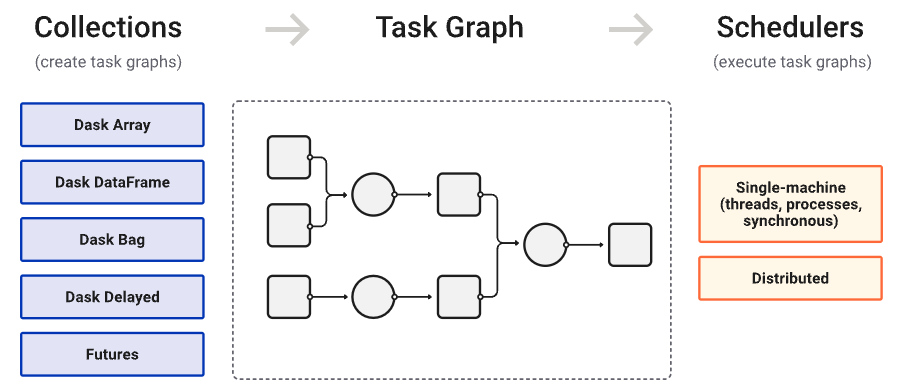 (image from Dask documentation https://docs.dask.org/en/stable/ )

Dask has a "dataframe", which can easily be constructed from its _pandas_ equivalent.
Let's use our "match_results.csv" for input again:

In [8]:
import dask.dataframe as dd
import numpy as np
import pandas as pd

In [9]:
df = pd.read_csv("match_results.csv")
ddf = dd.from_pandas(df, npartitions=10)
ddf

,Unnamed: 0,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
npartitions=10,,,,,,,,,,
0,int64,object,object,object,int64,int64,object,object,object,bool
4406,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...
39654,...,...,...,...,...,...,...,...,...,...
44059,...,...,...,...,...,...,...,...,...,...


The _Dask_ dataframe has 10 partitions, meaning that the 44k rows in the original csv are now divided into 10 batches of about 4.4k rows each.

In [10]:
ddf.divisions

(0, 4406, 8812, 13218, 17624, 22030, 26436, 30842, 35248, 39654, 44059)

The interface is very similar to _pandas_, with one important difference.
For example, if we want to calculate the average of the "home_score" column, in _pandas_ we can do: 

In [11]:
df.home_score.values.mean()

1.7404675442578301

If we do the same in our _Dask_ dataframe:

In [12]:
ddf.home_score.values.mean()

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

what we get back is the **Task Graph**.
In order to actually run the calculation, we need to add `compute()`:

In [13]:
ddf.home_score.values.mean().compute()

1.7404675442578301

Let's try and do something more complicated.
We can use the dataset to investigate whether "home advantage" is real, in international men's football matches.
We have columns in the dataset for "home_team", "away_team" etc., but some of the matches were at tournaments in neutral territory, so we want to use the "neutral" column to exclude these.
Having done that, we can just calculate the number of matches that the home team won, minus the number that the home team lost.

In [14]:
def home_team_wins(home_score, away_score, neutral):
    if neutral:
        return 0
    if home_score > away_score:  # home win
        return 1
    elif home_score < away_score:  # away win
        return -1
    else:  # draw
        return 0

In [15]:
ddf["home_win"] = df.apply(
    lambda row: home_team_wins(row["home_score"], row["away_score"], row["neutral"]),
    axis=1,
)
result = ddf["home_win"].values.sum()

The Task Graph for this computation, on our dataframe with 10 partitions, looks like this:
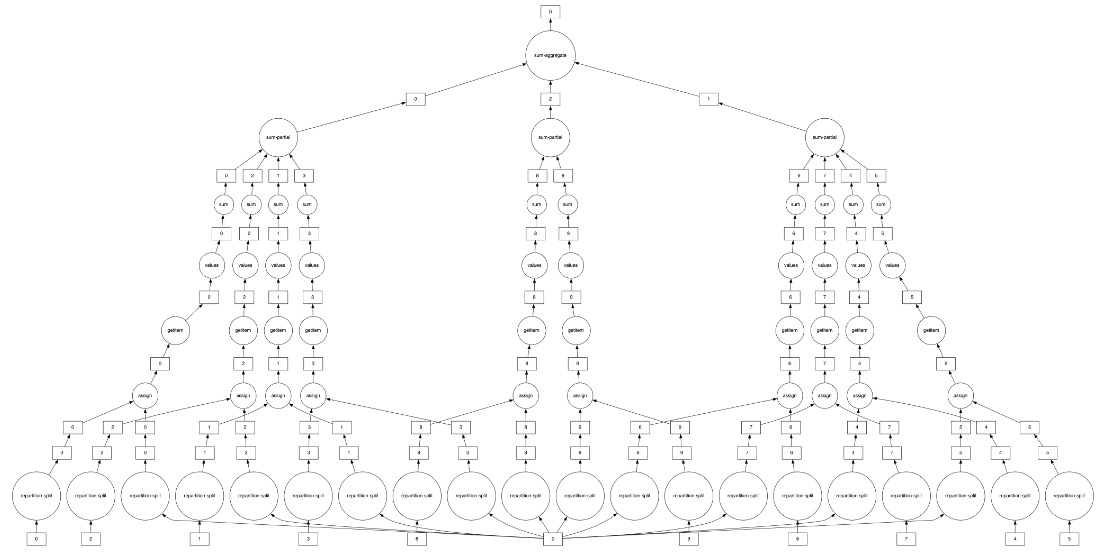

Note that you can create this visualization for yourself, if you install the _graphviz_ package (e.g. `brew install graphviz` on Mac) then install the Python graphviz package (`pip install graphviz`), then do `result.visualize()`.

Don't worry about the details, but we can see the 10 data partitions at the bottom, and the single result at the top, and a bunch of clever intermediate steps that Dask is figuring out for us.



At this point we can create either a local scheduler, or if we have a handy compute cluster, a distributed scheduler.
Either way, we do this by creating an instance of the `dask.distributed.Client` class, with the URL of the scheduler.

There are instructions on setting up a Dask cluster here: https://docs.dask.org/en/stable/deploying.html but for now, let's just run on our local machine, with a local scheduler.

In [16]:
from dask.distributed import Client

client = Client()  # or Client("<scheduler URL>") for remote cluster
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 15.61 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34371,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 15.61 GiB
Comm: tcp://127.0.0.1:43709,Total threads: 1
Dashboard: http://127.0.0.1:34425/status,Memory: 3.90 GiB
Nanny: tcp://127.0.0.1:45867,


Note the link to the dashboard - this will provide some diagnostics into what the scheduler is doing.

Once we have created a client, whenever we call `compute()` it will run on the scheduler that the client points to (in this case a local scheduler

In [17]:
result.compute()

8061

So, in our dataset, home teams won 8k times more often than away teams, so it seems that home advantage is a real thing!